## Overturning in density space

This is a test notebook for computing overturning in density space using `xgcm` and `xhitogram` libraries. Here, we use monthly data for one hindcast and one ensemble member. We follow the approach of the following example.

https://xgcm.readthedocs.io/en/latest/transform.html#Conservative-Interpolation

In [1]:
from xgcm import Grid
from xhistogram.xarray import histogram
import xarray as xr
import cf_xarray
import gsw as gsw
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client, performance_report
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar, visualize

In [2]:
#client = Client(n_workers=4)

#print(client)

In [3]:
var_list = ['thetao', 'so', 'vo', 'uo']

ppdir="/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/"

year, r = (2010, 0) 

ds = []
for var in var_list:
    
    var_path = "s" + str(year) +"-r" + str(r+1) + "i1p1f2/Omon/"+ var +"/gn/files/d20200417/"
    ds1 = xr.open_mfdataset(ppdir + var_path + "*gn_2010*.nc", decode_times=False)
    
    if(var == 'uo'):
        ds1 = ds1.rename({'i':'i_c', 'longitude':'longitude_u', 'latitude':'latitude_u', 'vertices_latitude':'vertices_latitude_u', 
                        'vertices_longitude':'vertices_longitude_u'})
    
    elif(var == 'vo'):
        ds1 = ds1.rename({'j':'j_c', 'longitude':'longitude_v', 'latitude':'latitude_v', 'vertices_latitude':'vertices_latitude_v', 
                        'vertices_longitude':'vertices_longitude_v'})
    
    
    #if(var =='vo'):
    #    ds1 = ds1.isel(i=slice(749,1199), j_c = slice(699, 1149))
    #else:
    #    ds1 = ds1.isel(i=slice(749,1199), j = slice(699, 1149))
        
    ds.append(ds1)
    
ds = xr.merge(ds)

In [4]:
# create outer depth levels

level_outer_data = cf_xarray.bounds_to_vertices(ds.lev_bnds, 'bnds').load().data

ds = ds.assign_coords({'level_outer': level_outer_data})

print(ds)

<xarray.Dataset>
Dimensions:               (time: 2, bnds: 2, lev: 75, j: 1205, i: 1440,
                           vertices: 4, j_c: 1205, i_c: 1440, level_outer: 76)
Coordinates: (12/13)
  * time                  (time) float64 5.792e+04 5.794e+04
  * lev                   (lev) float64 0.5058 1.556 ... 5.698e+03 5.902e+03
  * j                     (j) int32 0 1 2 3 4 5 ... 1200 1201 1202 1203 1204
  * i                     (i) int32 0 1 2 3 4 5 ... 1435 1436 1437 1438 1439
    latitude              (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude             (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    ...                    ...
    latitude_v            (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude_v           (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
  * i_c                   (i_c) int32 0 1 2 3 4 5 ... 1435 1436 1437 1438 1439
    latitude_u            (j, i_c

In [5]:
ds.thetao

<xarray.DataArray 'thetao' (time: 2, lev: 75, j: 1205, i: 1440)>
dask.array<open_dataset-a9f286510449cb570a10e18e9bc77b4ethetao, shape=(2, 75, 1205, 1440), dtype=float32, chunksize=(2, 75, 1205, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) float64 5.792e+04 5.794e+04
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * j          (j) int32 0 1 2 3 4 5 6 7 ... 1198 1199 1200 1201 1202 1203 1204
  * i          (i) int32 0 1 2 3 4 5 6 7 ... 1433 1434 1435 1436 1437 1438 1439
    latitude   (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
Attributes:
    standard_name:  sea_water_potential_temperature
    long_name:      Sea Water Potential Temperature
    comment:        mo: This variable is reported using a z* coordinate syste...
    units:          degC
    original_name:  mo: (variable_name: thetao)
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello

### Create grid information

In [6]:
grid = Grid(ds, coords={'Z': {'center': 'lev', 'outer': 'level_outer'},
                        'X': {'center': 'i', 'right': 'i_c'},
                        'Y': {'center': 'j', 'right': 'j_c'}}, periodic=['X'],)
grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   lev --> outer
  * outer    level_outer --> center
X Axis (periodic, boundary=None):
  * center   i --> right
  * right    i_c --> center
Y Axis (not periodic, boundary=None):
  * center   j --> right
  * right    j_c --> center

In [7]:
thickness = grid.diff(ds.level_outer, 'Z')
v_transport =  ds.vo * thickness
v_transport = v_transport.fillna(0.).rename('v_transport')
v_transport

<xarray.DataArray 'v_transport' (time: 2, lev: 75, j_c: 1205, i: 1440)>
dask.array<where, shape=(2, 75, 1205, 1440), dtype=float64, chunksize=(2, 75, 1205, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) float64 5.792e+04 5.794e+04
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * i            (i) int32 0 1 2 3 4 5 6 ... 1433 1434 1435 1436 1437 1438 1439
  * j_c          (j_c) int32 0 1 2 3 4 5 6 ... 1199 1200 1201 1202 1203 1204
    latitude_v   (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>

### Tranform from Z to theta

Here, we transform meridional tranport data from $z$ to $\theta$ coordinate. We further compare $\psi(z)$ and $\psi(\theta)$. 

In [16]:
ds['theta'] = grid.interp(ds.thetao, ['Y'], boundary='extend')
ds.theta

<xarray.DataArray 'theta' (time: 2, lev: 75, j_c: 1205, i: 1440)>
dask.array<mul, shape=(2, 75, 1205, 1440), dtype=float32, chunksize=(2, 75, 1204, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) float64 5.792e+04 5.794e+04
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * i            (i) int32 0 1 2 3 4 5 6 ... 1433 1434 1435 1436 1437 1438 1439
  * j_c          (j_c) int32 0 1 2 3 4 5 6 ... 1199 1200 1201 1202 1203 1204
    latitude_v   (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>

In [17]:
target_theta_levels = np.arange(-2, 36)

v_transport_theta = grid.transform(v_transport, 'Z', target_theta_levels,
                                   target_data=ds.theta, method='conservative')
v_transport_theta

/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/xgcm/grid.py:1045: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


<xarray.DataArray 'v_transport' (time: 2, j_c: 1205, i: 1440, theta: 37)>
dask.array<transpose, shape=(2, 1205, 1440, 37), dtype=float64, chunksize=(2, 1204, 1440, 37), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) float64 5.792e+04 5.794e+04
  * i            (i) int32 0 1 2 3 4 5 6 ... 1433 1434 1435 1436 1437 1438 1439
  * j_c          (j_c) int32 0 1 2 3 4 5 6 ... 1199 1200 1201 1202 1203 1204
    latitude_v   (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
  * theta        (theta) float64 -1.5 -0.5 0.5 1.5 2.5 ... 31.5 32.5 33.5 34.5

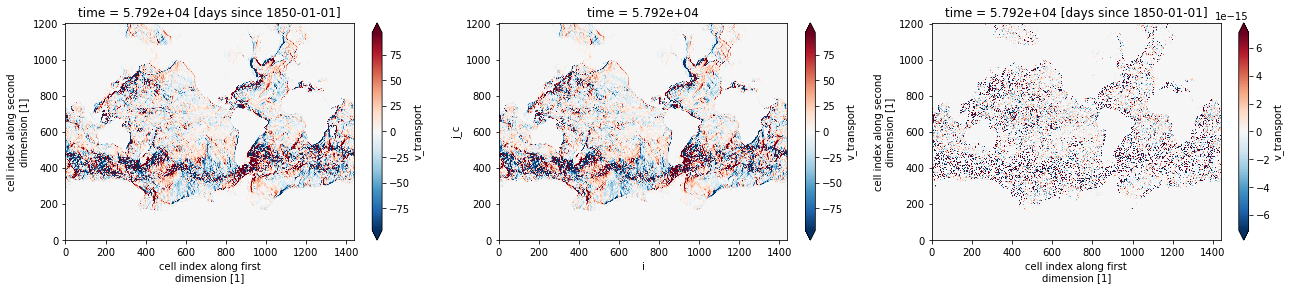

In [20]:
fig = plt.figure(figsize=[22,4])
    
plt.subplot(1,3,1)
tmp_z = v_transport.isel(time=0).sum(dim='lev').compute()
tmp_z.plot(robust=True)
    
plt.subplot(1,3,2)
tmp_theta = v_transport_theta.isel(time=0).sum(dim='theta').compute()
tmp_theta.plot(robust=True)

plt.subplot(1,3,3)
(tmp_z - tmp_theta).plot(robust=True)

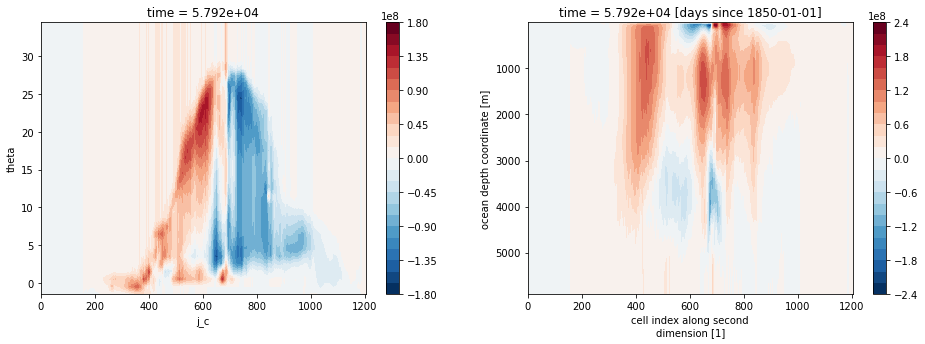

In [25]:
# compute overturning circulation

dx = 110e3 * np.cos(np.deg2rad(ds.latitude_v))

psi_theta = (v_transport_theta.isel(time=0) * dx).sum(dim='i').cumsum(dim='theta').compute()
psi_z = (v_transport.isel(time=0) * dx).sum(dim='i').cumsum(dim='lev').compute()

fig = plt.figure(figsize=[16,5])
plt.subplot(1,2,1)
psi_theta.plot.contourf(x='j_c', levels=31)

plt.subplot(1,2,2)
psi_z.plot.contourf(x='j_c', levels=31)
plt.gca().invert_yaxis()

### Transform to density coordinates

In [8]:
def pdens(S,theta):

    pot_dens = gsw.density.sigma0(S, theta)

    return pot_dens

sigma = xr.apply_ufunc(pdens, ds.so, ds.thetao, dask='parallelized', output_dtypes=[ds.thetao.dtype])

ds['sigma0'] = grid.interp(sigma, ['Y'], boundary='extend').compute()

ds['sigma0']

<xarray.DataArray 'sigma0' (time: 2, lev: 75, j_c: 1205, i: 1440)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * time         (time) float64 5.792e+04 5.794e+04
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * i            (i) int32 0 1 2 3 4 5 6 ... 1433 1434 1435 1436 1437 1438 1439
  * j_c          (j_c) int32 0 1 2 3 4 5 6 ... 1199 1200 1201 1202 1203 1204
    latitude_v   (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>

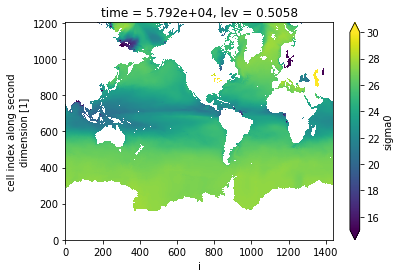

In [9]:
ds.sigma0.isel(time=0, lev=0).plot(vmin=15., vmax=30.)

In [10]:
target_sigma_levels = np.arange(18., 31., 0.2)

v_transport_sigma = grid.transform(v_transport, 'Z', target_sigma_levels,
                                   target_data=ds.sigma0, method='conservative')
v_transport_sigma

/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/xgcm/grid.py:1045: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


<xarray.DataArray 'v_transport' (time: 2, j_c: 1205, i: 1440, sigma0: 64)>
dask.array<transpose, shape=(2, 1205, 1440, 64), dtype=float64, chunksize=(2, 1205, 1440, 64), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) float64 5.792e+04 5.794e+04
  * i            (i) int32 0 1 2 3 4 5 6 ... 1433 1434 1435 1436 1437 1438 1439
  * j_c          (j_c) int32 0 1 2 3 4 5 6 ... 1199 1200 1201 1202 1203 1204
    latitude_v   (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
  * sigma0       (sigma0) float64 18.1 18.3 18.5 18.7 ... 30.1 30.3 30.5 30.7

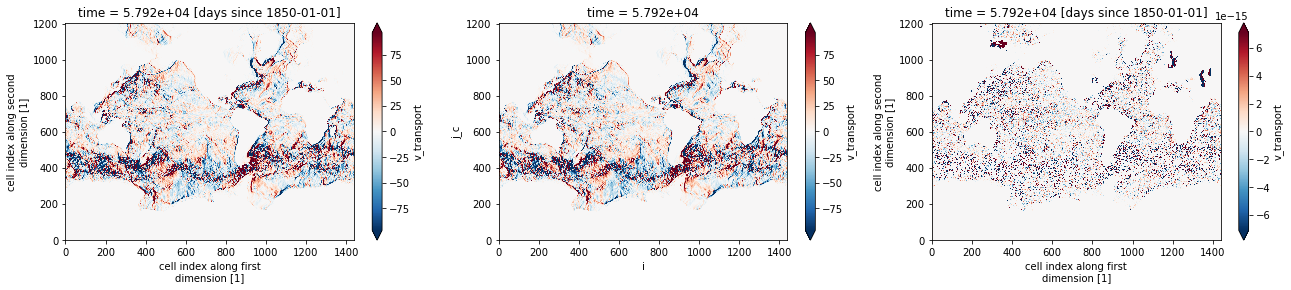

In [11]:
fig = plt.figure(figsize=[22,4])
    
plt.subplot(1,3,1)
tmp_z = v_transport.isel(time=0).sum(dim='lev').compute()
tmp_z.plot(robust=True)
    
plt.subplot(1,3,2)
tmp_sigma = v_transport_sigma.isel(time=0).sum(dim='sigma0').compute()
tmp_sigma.plot(robust=True)

plt.subplot(1,3,3)
(tmp_z - tmp_sigma).plot(robust=True)

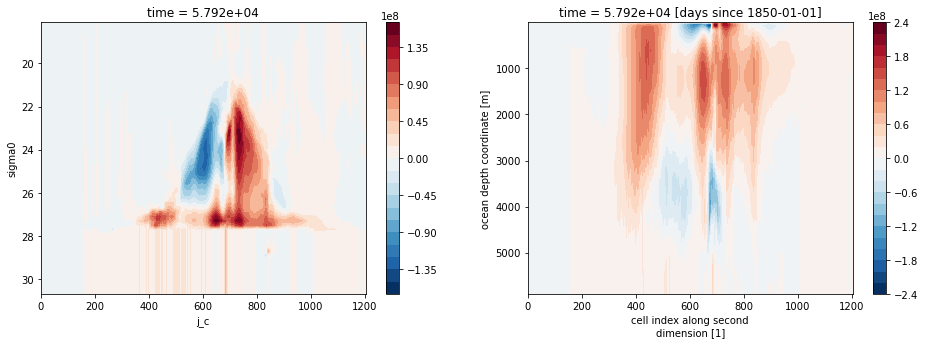

In [12]:
# compute overturning circulation

dx = 110e3 * np.cos(np.deg2rad(ds.latitude_v))

psi_sigma = (v_transport_sigma.isel(time=0) * dx).sum(dim='i').cumsum(dim='sigma0').compute()
psi_z = (v_transport.isel(time=0) * dx).sum(dim='i').cumsum(dim='lev').compute()

fig = plt.figure(figsize=[16,5])
plt.subplot(1,2,1)
psi_sigma.plot.contourf(x='j_c', levels=31)
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
psi_z.plot.contourf(x='j_c', levels=31)
plt.gca().invert_yaxis()

### Only for North Atlantic region

Only consider the north atlantic region

In [28]:
ds_mask = xr.open_dataset("../../../../DePreSys4_Data/Data_Consolidated/Mask_Regions.nc")

ds_mask = ds_mask.rename({'j':'j_c'})

print(ds_mask)

ds_grid = xr.open_dataset("../../../../DePreSys4_Data/Data_Consolidated/Ocean_Area_Updated.nc")

print(ds_grid)

<xarray.Dataset>
Dimensions:         (j_c: 450, i: 450)
Coordinates:
  * j_c             (j_c) int64 699 700 701 702 703 ... 1144 1145 1146 1147 1148
  * i               (i) int64 749 750 751 752 753 ... 1194 1195 1196 1197 1198
    nav_lat         (j_c, i) float32 ...
    nav_lon         (j_c, i) float32 ...
Data variables:
    mask_regions    (j_c, i) float64 ...
    mask_North_Atl  (j_c, i) float64 ...
<xarray.Dataset>
Dimensions:    (y: 450, x: 450, deptht: 75, depthw: 75, xu: 450, yv: 450)
Coordinates:
    nav_lat    (y, x) float32 ...
    nav_lon    (y, x) float32 ...
  * deptht     (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * depthw     (depthw) float32 0.0 1.024 2.103 ... 5.393e+03 5.596e+03 5.8e+03
Dimensions without coordinates: y, x, xu, yv
Data variables: (12/15)
    area_t     (y, x) float32 ...
    dz_t       (deptht) float32 ...
    dz_w       (depthw) float32 ...
    area_u     (y, xu) float32 ...
    area_v     (yv, x) float32 ...
    dx_t       (y, 

In [30]:
ds_NA = ds.isel(i=slice(749,1199), j = slice(699, 1149), i_c=slice(749,1199), j_c = slice(699, 1149))

ds_NA = xr.merge([ds_NA, ds_mask, ds_grid['dx_v'].rename({'x':'i', 'yv':'j_c'})])

ds_NA

<xarray.Dataset>
Dimensions:               (i: 450, j_c: 450, time: 2, bnds: 2, lev: 75, j: 450,
                           vertices: 4, i_c: 450, level_outer: 76)
Coordinates: (12/15)
  * i                     (i) int64 749 750 751 752 753 ... 1195 1196 1197 1198
  * j_c                   (j_c) int64 699 700 701 702 ... 1145 1146 1147 1148
  * time                  (time) float64 5.792e+04 5.794e+04
  * lev                   (lev) float64 0.5058 1.556 ... 5.698e+03 5.902e+03
  * j                     (j) int32 699 700 701 702 703 ... 1145 1146 1147 1148
    latitude              (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    ...                    ...
  * i_c                   (i_c) int32 749 750 751 752 ... 1195 1196 1197 1198
    latitude_u            (j, i_c) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude_u           (j, i_c) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
  * level_outer           (level_outer) float64 0.0 1.024 ... 5.8e+03 6.004e+03
    nav_lat               (j_c, i) float32 ...
    nav_lon               (j_c, i) float32 ...
Dimensions without coordinates: bnds, vertices
Data variables: (12/16)
    time_bnds             (time, bnds) float64 dask.array<chunksize=(2, 2), meta=np.ndarray>
    lev_bnds              (lev, bnds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
    vertices_latitude     (j, i, vertices) float32 dask.array<chunksize=(450, 450, 4), meta=np.ndarray>
    vertices_longitude    (j, i, vertices) float32 dask.array<chunksize=(450, 450, 4), meta=np.ndarray>
    thetao                (time, lev, j, i) float32 dask.array<chunksize=(2, 75, 450, 450), meta=np.ndarray>
    so                    (time, lev, j, i) float32 dask.array<chunksize=(2, 75, 450, 450), meta=np.ndarray>
    ...                    ...
    vertices_longitude_u  (j, i_c, vertices) float32 dask.array<chunksize=(450, 450, 4), meta=np.ndarray>
    uo                    (time, lev, j, i_c) float32 dask.array<chunksize=(2, 75, 450, 450), meta=np.ndarray>
    sigma0                (time, lev, j_c, i) float64 22.02 22.02 ... nan nan
    mask_regions          (j_c, i) float64 ...
    mask_North_Atl        (j_c, i) float64 ...
    dx_v                  (j_c, i) float32 ...
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2021-03-01T08:58:11Z
    ...                     ...
    tracking_id:            hdl:21.14100/0c7c3929-d043-48a8-8b98-24ac6e95c274
    variable_id:            thetao
    variable_name:          thetao
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by Met Office Hadley Ce...
    cmor_version:           3.4.0

In [31]:
grid = Grid(ds_NA, coords={'Z': {'center': 'lev', 'outer': 'level_outer'},
                           'X': {'center': 'i', 'right': 'i_c'},
                           'Y': {'center': 'j', 'right': 'j_c'}}, periodic=[],)
grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   lev --> outer
  * outer    level_outer --> center
X Axis (not periodic, boundary=None):
  * center   i --> right
  * right    i_c --> center
Y Axis (not periodic, boundary=None):
  * center   j --> right
  * right    j_c --> center

In [32]:
thickness = grid.diff(ds_NA.level_outer, 'Z')
v_transport_NA =  ds_NA.vo * thickness
v_transport_NA = v_transport_NA.fillna(0.).rename('v_transport_NA')
v_transport_NA

<xarray.DataArray 'v_transport_NA' (time: 2, lev: 75, j_c: 450, i: 450)>
dask.array<where, shape=(2, 75, 450, 450), dtype=float64, chunksize=(2, 75, 450, 450), chunktype=numpy.ndarray>
Coordinates:
  * i            (i) int64 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
  * j_c          (j_c) int64 699 700 701 702 703 ... 1144 1145 1146 1147 1148
  * time         (time) float64 5.792e+04 5.794e+04
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    latitude_v   (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    nav_lat      (j_c, i) float32 ...
    nav_lon      (j_c, i) float32 ...

In [40]:
def pdens(S,theta):

    pot_dens = gsw.density.sigma0(S, theta)

    return pot_dens

sigma = xr.apply_ufunc(pdens, ds_NA.so, ds_NA.thetao, dask='parallelized', output_dtypes=[ds_NA.thetao.dtype])

ds_NA['sigma0'] = grid.interp(sigma, ['Y'], boundary='extend').compute()

ds_NA['sigma0']

<xarray.DataArray 'sigma0' (time: 2, lev: 75, j_c: 450, i: 450)>
array([[[[22.01698831, 22.01570173, 22.0156339 , ...,         nan,
                  nan,         nan],
         [21.93769384, 21.93436748, 21.9330445 , ...,         nan,
                  nan,         nan],
         [21.86540533, 21.85929153, 21.85478241, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ..., 27.53059921,
          27.51926593, 27.47980372],
         [        nan,         nan,         nan, ..., 27.5187215 ,
          27.47882426, 27.38948744],
         [        nan,         nan,         nan, ..., 27.50398072,
          27.4426769 , 27.33235802]],

        [[22.01942487, 22.01807846, 22.0180055 , ...,         nan,
                  nan,         nan],
         [21.94034859, 21.93698542, 21.93561866, ...,         nan,
                  nan,         nan],
         [21.86850162, 21.86236862, 21.85773752, ...,         nan,
                  nan,         nan],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]])
Coordinates:
  * i            (i) int64 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
  * j_c          (j_c) int64 699 700 701 702 703 ... 1144 1145 1146 1147 1148
  * time         (time) float64 5.792e+04 5.794e+04
  * lev          (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    latitude_v   (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    nav_lat      (j_c, i) float32 ...
    nav_lon      (j_c, i) float32 ...

In [44]:
target_sigma_levels = np.arange(18., 31., 0.2)

v_transport_NA_sigma = grid.transform(v_transport_NA, 'Z', target_sigma_levels,
                                   target_data=ds_NA.sigma0, method='conservative')
v_transport_NA_sigma

/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/xgcm/grid.py:1045: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/home/users/hkhatri/miniconda3/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


<xarray.DataArray 'v_transport_NA' (time: 2, j_c: 450, i: 450, sigma0: 64)>
dask.array<transpose, shape=(2, 450, 450, 64), dtype=float64, chunksize=(2, 450, 450, 64), chunktype=numpy.ndarray>
Coordinates:
  * i            (i) int64 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
  * j_c          (j_c) int64 699 700 701 702 703 ... 1144 1145 1146 1147 1148
  * time         (time) float64 5.792e+04 5.794e+04
    latitude_v   (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude_v  (j_c, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    nav_lat      (j_c, i) float32 ...
    nav_lon      (j_c, i) float32 ...
  * sigma0       (sigma0) float64 18.1 18.3 18.5 18.7 ... 30.1 30.3 30.5 30.7

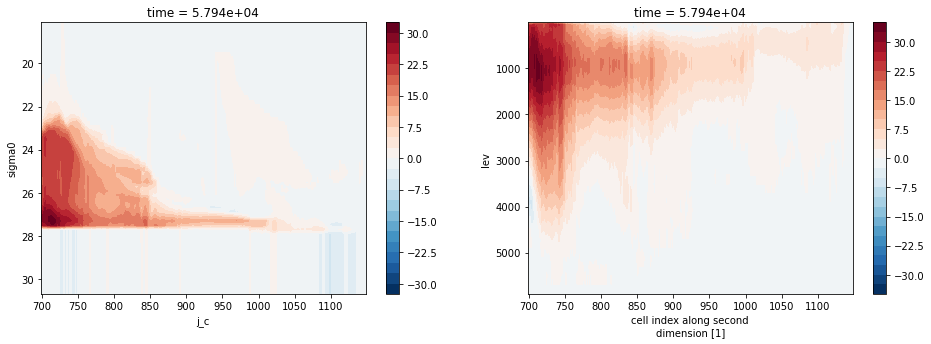

In [69]:
dx = ds_NA['dx_v']

psi_sigma_NA = ((v_transport_NA_sigma.isel(time=1) * dx).where(ds_NA.mask_North_Atl==0.)).sum(dim='i').cumsum(dim='sigma0').compute()
psi_z_NA = ((v_transport_NA.isel(time=1) * dx).where(ds_NA.mask_North_Atl==0.)).sum(dim='i').cumsum(dim='lev').compute()

fig = plt.figure(figsize=[16,5])
plt.subplot(1,2,1)
(psi_sigma_NA/1e6 - 0*psi_sigma_NA.isel(sigma0=-1)/1e6).plot.contourf(x='j_c', levels=31)
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
(psi_z_NA/1e6 - psi_z_NA.isel(lev=-1)/1e6).plot.contourf(x='j_c', levels=31)
plt.gca().invert_yaxis()

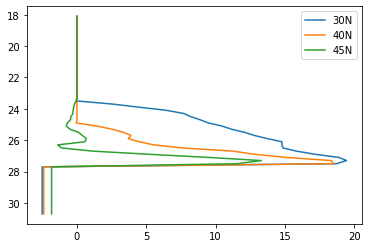

In [67]:
# t=0
plt.plot(psi_sigma_NA.sel(j_c=809)/1e6, psi_sigma.sigma0, label='30N')
plt.plot(psi_sigma_NA.sel(j_c=860)/1e6, psi_sigma.sigma0, label='40N')
plt.plot(psi_sigma_NA.sel(j_c=890)/1e6, psi_sigma.sigma0, label='45N')
plt.gca().invert_yaxis()
plt.legend()

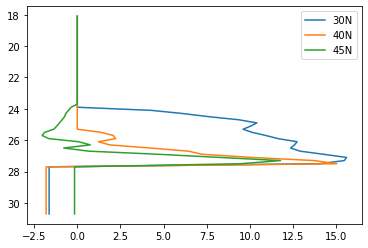

In [70]:
# t=1
plt.plot(psi_sigma_NA.sel(j_c=809)/1e6, psi_sigma.sigma0, label='30N')
plt.plot(psi_sigma_NA.sel(j_c=860)/1e6, psi_sigma.sigma0, label='40N')
plt.plot(psi_sigma_NA.sel(j_c=890)/1e6, psi_sigma.sigma0, label='45N')
plt.gca().invert_yaxis()
plt.legend()

In [66]:
ds_NA.latitude_v.sel(j_c=860).values

array([39.547806, 39.549393, 39.551037, 39.552727, 39.554474, 39.55627 ,
       39.558117, 39.560017, 39.56197 , 39.56397 , 39.56602 , 39.568127,
       39.57028 , 39.572483, 39.574738, 39.57704 , 39.579395, 39.5818  ,
       39.584248, 39.58675 , 39.5893  , 39.591896, 39.59454 , 39.597233,
       39.599976, 39.602764, 39.6056  , 39.608482, 39.61141 , 39.614384,
       39.617405, 39.620472, 39.623585, 39.62674 , 39.62994 , 39.633186,
       39.63648 , 39.639812, 39.64319 , 39.646606, 39.65007 , 39.653576,
       39.657124, 39.660713, 39.664345, 39.66802 , 39.67173 , 39.675484,
       39.679276, 39.68311 , 39.68698 , 39.69089 , 39.694843, 39.69883 ,
       39.702854, 39.706917, 39.711018, 39.715153, 39.719326, 39.723534,
       39.72778 , 39.732056, 39.73637 , 39.74072 , 39.7451  , 39.749516,
       39.75396 , 39.758442, 39.762955, 39.767498, 39.77207 , 39.776676,
       39.78131 , 39.785976, 39.790672, 39.795395, 39.800148, 39.804928,
       39.80974 , 39.81457 , 39.819435, 39.82432 , 

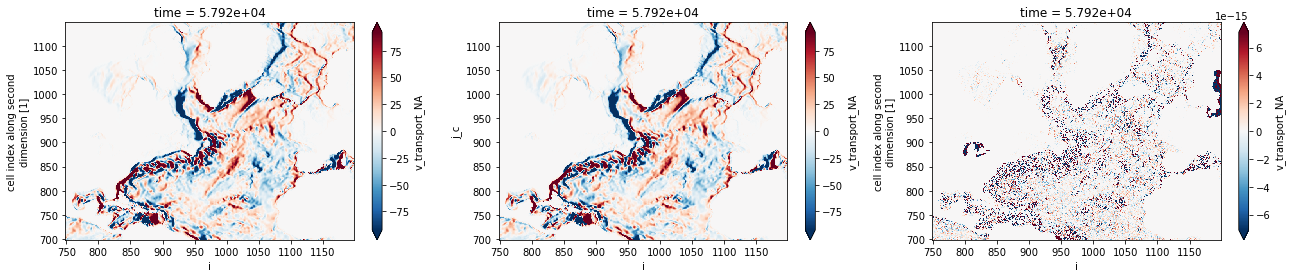

In [68]:
fig = plt.figure(figsize=[22,4])
    
plt.subplot(1,3,1)
tmp_z = v_transport_NA.isel(time=0).sum(dim='lev').compute()
tmp_z.plot(robust=True)
    
plt.subplot(1,3,2)
tmp_sigma = v_transport_NA_sigma.isel(time=0).sum(dim='sigma0').compute()
tmp_sigma.plot(robust=True)

plt.subplot(1,3,3)
(tmp_z - tmp_sigma).plot(robust=True)

## lat-on checks for u,v grids

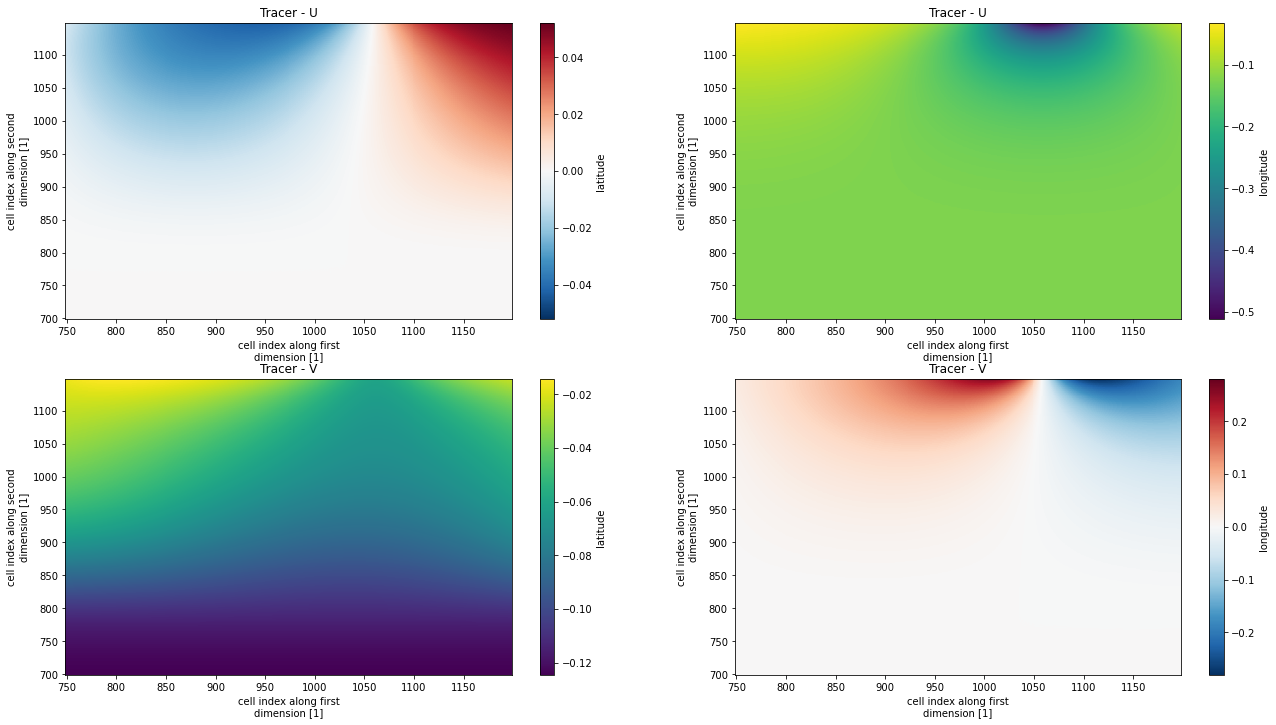

In [4]:

fig = plt.figure(figsize=[22,12])

plt.subplot(2,2,1)
(ds[0].latitude - ds[2].latitude).plot()
plt.title('Tracer - U')

plt.subplot(2,2,2)
(ds[0].longitude - ds[2].longitude).plot()
plt.title('Tracer - U')

plt.subplot(2,2,3)
(ds[0].latitude - ds[3].latitude).plot()
plt.title('Tracer - V');

plt.subplot(2,2,4)
(ds[0].longitude - ds[3].longitude).plot()
plt.title('Tracer - V');

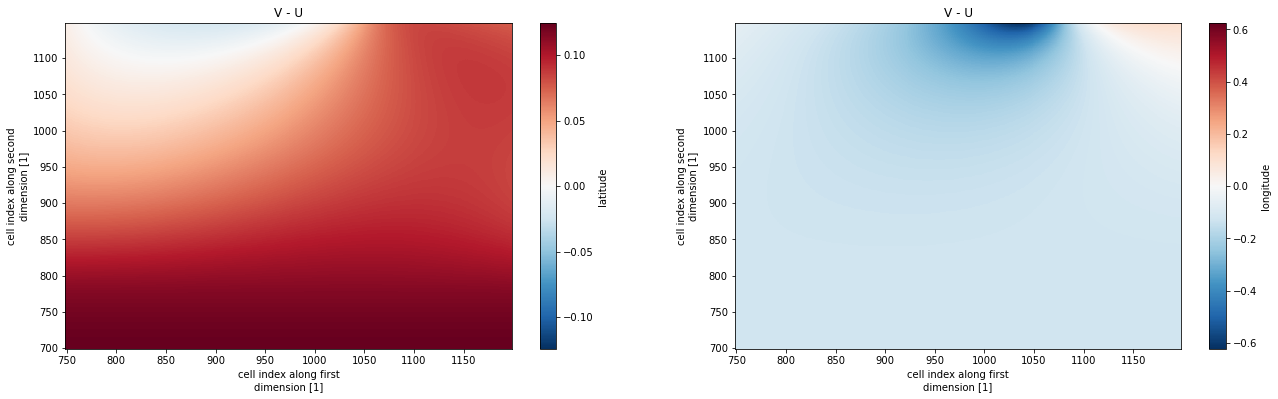

In [6]:
fig = plt.figure(figsize=[22,6])

plt.subplot(1,2,1)
(ds[3].latitude - ds[2].latitude).plot()
plt.title('V - U')

plt.subplot(1,2,2)
(ds[3].longitude - ds[2].longitude).plot()
plt.title('V - U');

Ideally on a C-grid, tracer and V points should be on longitudes. Similarly, tracer and U points should be on same latitudes. There are differences. Let's check this with original data downloaded from Met office archive.

The same issue is present in the test dataset. It seems that grid cells at high-latitudes are arranged in a way that lats/lons do not exactly match.

In [40]:
path = "/home/users/hkhatri/DePreSys4_Data/Test_Data/ONM_Monthly/"
ds_T = xr.open_mfdataset(path + "nemo_av830o_1m_19810301-19810401_grid-T.nc")
ds_U = xr.open_mfdataset(path + "nemo_av830o_1m_19810301-19810401_grid-U.nc")
ds_V = xr.open_mfdataset(path + "nemo_av830o_1m_19810301-19810401_grid-V.nc")

In [41]:
print(ds_T)

<xarray.Dataset>
Dimensions:                (y: 1207, x: 1442, nvertex: 4, deptht: 75,
                            axis_nbounds: 2, deptht300: 35, time_counter: 1)
Coordinates:
    nav_lat                (y, x) float32 dask.array<chunksize=(1207, 1442), meta=np.ndarray>
    nav_lon                (y, x) float32 dask.array<chunksize=(1207, 1442), meta=np.ndarray>
  * deptht                 (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
  * deptht300              (deptht300) float32 0.5058 1.556 ... 271.4 300.9
    time_centered          (time_counter) object dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter           (time_counter) float64 0.0
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables: (12/74)
    bounds_lon             (y, x, nvertex) float32 dask.array<chunksize=(1207, 1442, 4), meta=np.ndarray>
    bounds_lat             (y, x, nvertex) float32 dask.array<chunksize=(1207, 1442, 4), meta=np.ndarray>
    area                   (y, x) f

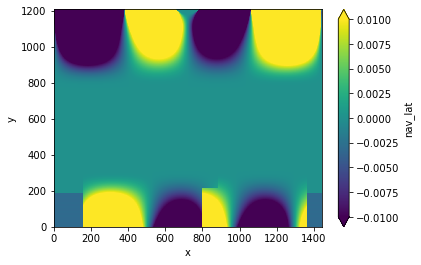

In [14]:
(ds_T.nav_lat - ds_U.nav_lat).plot(vmin=-1e-2, vmax=1e-2)

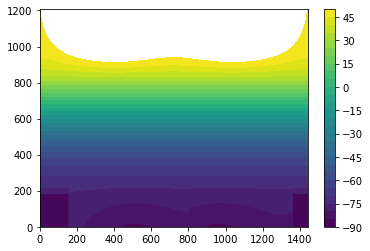

In [49]:
plt.contourf(ds_T.nav_lat.where(ds_T.nav_lat<50.), 30)
plt.colorbar()

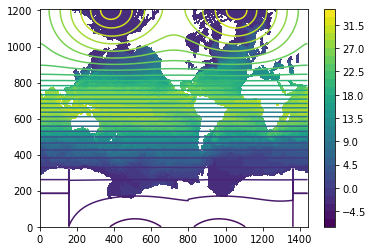

In [59]:
plt.contourf(ds_T.tos.isel(time_counter=0), 30)
plt.colorbar()
plt.contour(ds_T.nav_lat, 30)